In [1]:
# Utilities
import os
import math
import numpy as np
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns
sns.set()
%matplotlib inline
set_matplotlib_formats("svg", "pdf")

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import torchvision.io as io
import torchmetrics
from torchmetrics.classification import Accuracy, F1Score, Precision, Recall
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, ModelSummary

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_float32_matmul_precision("high")
print(f"Running on {device}")

# Data pre-processing
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight

Running on cuda


# Dataset

In [9]:
class UnibucBrainScans(data.Dataset):
    classes = ["Normal", "Anomaly"]
    def __init__(self, root, train=True, transform=None, target_transform=None, rgb=False):
        self.root = root
        if train:
            train = pd.read_csv(os.path.join(root, "train_labels.txt"), dtype={0: str, 1: int})
            validation = pd.read_csv(os.path.join(root, "validation_labels.txt"), dtype={0: str, 1: int})
            self.labels = pd.concat([train, validation])
        else:
            files = np.arange(17001, 22149, 1)
            df = pd.DataFrame(files)
            df[0] = df[0].astype(str).str.zfill(6)
            df[1] = np.random.randint(low=0, high=2, size=files.shape)
            self.labels = df
                
        self.transform = transform
        self.target_transform = target_transform
        self.rgb = rgb

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, f"data/{self.labels.iloc[idx, 0]}.png")
        image = io.read_image(img_path, mode=io.ImageReadMode.RGB if self.rgb else io.ImageReadMode.GRAY).float() / 255.0
        label = torch.tensor(self.labels.iloc[idx, 1], dtype=torch.int64)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def class_weights(self):
        labels = self.labels.iloc[:, 1].to_numpy()
        return torch.from_numpy(compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels))
        

# Model

In [ ]:
class BrainClassifier(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 4, 33),   #  4 @ 212x212
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    #  4 @ 106x106
            nn.Conv2d(4, 16, 17),  # 16 @ 90x90
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # 16 @ 45x45
            nn.Conv2d(16, 16, 14), # 16 @ 32x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2),    # 16 @ 16x16

            nn.Flatten(1),
    
            nn.Linear(2704, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2),
        )

        self.save_hyperparameters()

        self.class_weights = class_weights
        self.example_input_array = torch.zeros((1, 1, 224, 224), dtype=torch.float32)

        self.validation_metrics = torchmetrics.MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            Precision(task="binary"),
            Recall(task="binary"),
        ], prefix="validation_")

        self.test_metrics = torchmetrics.MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            Precision(task="binary"),
            Recall(task="binary"),
        ], prefix="test_")

    def forward(self, x):
        return self.layers(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)

        weight = torch.where(y.argmax(dim=-1) == 0, self.class_weights[0], self.class_weights[1]).reshape(-1, 1)
        criterion = nn.BCEWithLogitsLoss(weight=weight)
        loss = criterion(yhat, y)
        self.log("train_Loss", loss)
        
        return loss

    def validation_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)

        weight = torch.where(y.argmax(dim=-1) == 0, self.class_weights[0], self.class_weights[1]).reshape(-1, 1)
        criterion = nn.BCEWithLogitsLoss(weight=weight)
        loss = criterion(yhat, y)
        self.log("validation_Loss", loss)

        preds, truth = yhat.argmax(dim=-1), y.argmax(dim=-1)
        self.validation_metrics.update(preds, truth)
        self.log_dict(self.validation_metrics, on_step=False, on_epoch=True)

    def test_step(self, batch, i):
        x, y = batch
        yhat = self.layers(x)
        
        preds, truth = yhat.argmax(dim=-1), y.argmax(dim=-1)
        self.test_metrics.update(preds, truth)
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)

# MobileNetV3
My model's performance is shit, so here's mobilenet.

In [6]:
from torchvision.models import mobilenet_v3_small

class MobileNetV3Module(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        
        self.class_weights = class_weights
        self.classifier = mobilenet_v3_small(num_classes=2)

        self.example_input_array = torch.zeros((1, 3, 224, 224), dtype=torch.float32)

        self.validation_metrics = torchmetrics.MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            Precision(task="binary"),
            Recall(task="binary"),
        ], prefix="validation_")

        self.test_metrics = torchmetrics.MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            Precision(task="binary"),
            Recall(task="binary"),
        ], prefix="test_")
        
    
    def forward(self, x):
        return self.classifier(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, i):
        x, y = batch
        yhat = self.classifier(x)

        weight = torch.where(y.argmax(dim=-1) == 0, self.class_weights[0], self.class_weights[1]).reshape(-1, 1)
        criterion = nn.BCEWithLogitsLoss(weight=weight)
        loss = criterion(yhat, y)
        self.log("train_Loss", loss)
        
        return loss

    def validation_step(self, batch, i):
        x, y = batch
        yhat = self.classifier(x)

        weight = torch.where(y.argmax(dim=-1) == 0, self.class_weights[0], self.class_weights[1]).reshape(-1, 1)
        criterion = nn.BCEWithLogitsLoss(weight=weight)
        loss = criterion(yhat, y)
        self.log("validation_Loss", loss)

        preds, truth = yhat.argmax(dim=-1), y.argmax(dim=-1)
        self.validation_metrics.update(preds, truth)
        self.log_dict(self.validation_metrics, on_step=False, on_epoch=True)

    def test_step(self, batch, i):
        x, y = batch
        yhat = self.classifier(x)
        
        preds, truth = yhat.argmax(dim=-1), y.argmax(dim=-1)
        self.test_metrics.update(preds, truth)
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)

# Data preparation

In [3]:
def view_data(dataset, count):
    entries = [dataset[i] for i in range(min(count, len(dataset)))]
    
    ncols = 4
    fig, ax = plt.subplots(math.ceil(len(entries) / ncols), ncols, sharex=True, sharey=True, figsize=(10.0, 5.0))
    
    for i, (image, label) in enumerate(entries):
        image = np.transpose(image, (1, 2, 0))
        label = dataset.classes[label.argmax(dim=-1).int().item()]
        
        axi = ax[i // 4, i % 4]
        axi.imshow(image, cmap="gray", vmin=0.0, vmax=1.0)
        axi.text(0.5, -0.2, label, transform=axi.transAxes, fontsize=12, va="bottom", ha="center")
        axi.axis("off")

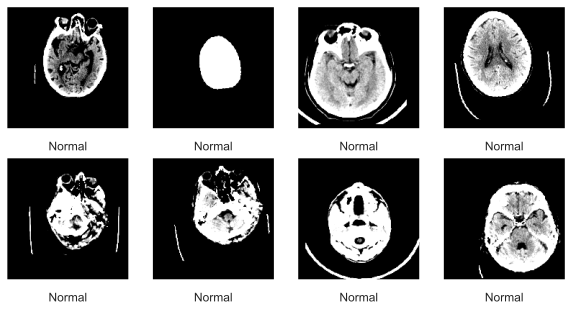

In [10]:
MEAN, STD = 0.0515, 0.1009

transform = T.Compose([
    T.Normalize(MEAN, STD),
    T.RandomHorizontalFlip(0.5),
    T.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 0.99))
])

target_transform = T.Compose([
    T.Lambda(lambda x: F.one_hot(x, num_classes=2).float()),
])

full_set = UnibucBrainScans(root="./data", train=True, transform=transform, target_transform=target_transform)
split = int(0.8 * len(full_set))
train_set, val_set = data.random_split(full_set, [split, len(full_set) - split])
view_data(full_set, 8)

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

# Training

In [5]:
def train(model_class, model_name, train_loader, val_loader, **kwargs):
    trainer = pl.Trainer(
        default_root_dir = "logs",
        accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
        devices = 1,
        max_epochs = 300,
        callbacks = [
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="validation_BinaryF1Score"),
            LearningRateMonitor("epoch"),
            ModelSummary(max_depth=-1),
        ],
        enable_progress_bar = True,
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    model = model_class(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = model_class.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

def test(model, loader):
    trainer = pl.Trainer(
        default_root_dir = "logs",
        accelerator = "gpu" if str(device).startswith("cuda") else "cpu",
        devices = 1,
        max_epochs = 50,
        enable_progress_bar = True
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    trainer.test(model, loader)

## Train BrainClassifier

In [ ]:
cw = full_set.class_weights()
print(f"Class weights: {cw.numpy()}")
model = train(BrainClassifier, "unibuc-brain-aug", train_loader, val_loader, class_weights=cw)

In [ ]:
test(model, val_loader)

## Train MobileNetV3

In [ ]:
cw = full_set.class_weights()
print(f"Class weights: {cw.numpy()}")
mobilenet = train(MobileNetV3Module, "unibuc-brain-mobilenet", train_loader, val_loader, class_weights=cw)

In [ ]:
test(mobilenet, val_loader)

# Layer activations & dead neurons

In [ ]:
@torch.no_grad
def visualize_activations(model, color="C0"):
    activations = {}

    model = model.to(device)
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    x, y = next(iter(small_loader))
    x, y = x.to(device), y.to(device)

    for i, layer in enumerate(model.layers):
        yhat = model(x)
        activations[i] = yhat.view(-1).cpu().numpy()

    ncols = 4
    nrows = math.ceil(len(activations) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2.7, nrows * 2.5), sharey=True, sharex=True)
    for i, key in enumerate(activations):
        axi = ax[i // ncols, i % ncols]
        sns.histplot(data=activations[key], bins=50, ax=axi, color=color, kde=True, stat="density")
        axi.set_title(f"Layer {key} - {model.layers[key].__class__.__name__}")

    fig.suptitle("Activation distribution for BrainClassifier", fontsize=14)
    # fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

@torch.no_grad
def count_dead_neurons(model, train_loader, color="C1"):
    neurons_dead = []

    dim = 224
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            neurons_dead.append(
                torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
            )
        elif isinstance(layer, nn.Conv2d):
            dim -= layer.weight.shape[2] - 1
            neurons_dead.append(
                torch.ones(dim, device=device, dtype=torch.bool)
            )
        elif isinstance(layer, nn.MaxPool2d):
            dim //= 2
                
    model = model.to(device)
    model.eval()
    for x, _ in train_loader:
        x = x.to(device)
        i = 0
        for layer in model.layers:
            x = layer(x)
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                neurons_dead[i] = torch.logical_and(neurons_dead[i], (x == 0).all(dim=0))
                i += 1

    counts = [t.sum().item() for t in neurons_dead]
    print("Dead neuron counts:", counts)
    print("Dead neuron %     :", [i / len(counts) for i in counts])

In [ ]:
# model = BrainClassifier(class_weights=class_weights)
# d = torch.load("logs/lightning_logs/version_2/checkpoints/epoch=88-step=18868.ckpt")
# model.load_state_dict(d["state_dict"])

count_dead_neurons(model, train_loader)
visualize_activations(model, color="C2")

# Model outputs

In [ ]:
@torch.no_grad()
def view_preds(model, loader):
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    model = model.to(device)
    model.eval()

    preds = model(x)
    
    ncols = 4
    fig, ax = plt.subplots(math.ceil(len(x) / ncols), ncols, sharex=True, sharey=True, figsize=(10.0, 10.0))
    
    for i, (image, label, pred) in enumerate(zip(x, y, preds)):
        image, label, pred = image.cpu().numpy(), label.cpu(), pred.cpu()
        
        image = (image * STD) + MEAN
        image = np.transpose(image, (1, 2, 0))
        label = UnibucBrainScans.classes[label.argmax(dim=-1).int().item()]
        pred = UnibucBrainScans.classes[pred.argmax(dim=-1).int().item()]
        
        axi = ax[i // 4, i % 4]
        axi.imshow(image, cmap="gray", vmin=0.0, vmax=1.0)

        col = "green" if pred == label else "red"
        axi.text(0.5, -0.15, pred, transform=axi.transAxes, fontsize=12, va="bottom", ha="center", color=col)
        axi.axis("off")

@torch.no_grad()
def view_confusion_matrix(model, loader):
    model = model.to(device)
    model.eval()
    ground, preds = torch.empty(0).to(device), torch.empty(0).to(device)
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        p = model(x).argmax(dim=-1)
        y = y.argmax(-1)
    
        ground = torch.cat((ground, y), 0)
        preds = torch.cat((preds, p), 0)

    ground, preds = ground.cpu().numpy(), preds.cpu().numpy()
    conf_matrix = ConfusionMatrixDisplay.from_predictions(ground, preds, display_labels=["Normal", "Anomaly"])
    plt.grid(False)

In [ ]:
test_set = UnibucBrainScans(root="./data", train=True, transform=transform, target_transform=target_transform)
test_loader = data.DataLoader(test_set, batch_size=16, shuffle=True, num_workers=4)

view_preds(model, test_loader)
view_confusion_matrix(model, test_loader)